## Analysing difference of Grid cell activation as a function of distance

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import string

In [249]:
N = 30
R = 20
num_points = 500

### Basic plots

In [250]:
def Lattice(l=1,l0=[0,0],t0=0,N=3):
    '''Return an array of x coordinates and y coordinates that create a hexagonal lattice
      of N^2 points of length l, rotated by theta t0 and displaced by l0  '''
    mlist = np.linspace(-N,N,2*N+1)
    nlist = np.linspace(-N,N,2*N+1)
    m,n = np.meshgrid(mlist,nlist)
    a0 = np.array([(3**0.5)/2,1/2]) *l
    b0 = np.array([(3**0.5)/2,-1/2]) *l
    # a = a0 + *l + l0[0]
    # b = np.array([3**0.5/2,-1/2]) *l + l0[1]

    # apply rotation
    theta = np.radians(t0)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    a,b = R@a0 + l0[0], R@b0 + l0[1]
    return np.outer(a,m.flatten()) + np.outer(b,n.flatten())

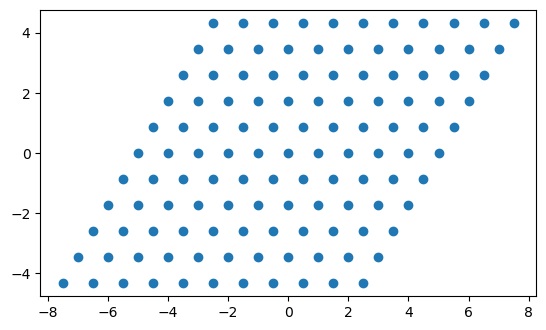

In [251]:
plt.scatter(*Lattice(l=1,t0=30,N=5))
# plt.set_aspect('equal', adjustable='box')
plt.axis('scaled')
plt.show()

The normal Gaussian is given by,
$$ \displaystyle g(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}\exp \left(-{\frac {1}{2}}{\frac {(x-\mu )^{2}}{\sigma ^{2}}}\right) $$

In [252]:
def GaussLattice(x,y,X,Y,s=1):
    ''' A function with periodic Gaussians centered at X,Y lattice'''
    exponent = (np.subtract.outer(X,x))**2  + (np.subtract.outer(Y,y))**2
    # print(exponent.shape)
    explat = np.exp(exponent / (-2*(s**2)))     # lattice of exponentials
    return np.sum(explat, axis=0)

In [253]:
X1,Y1 = Lattice(l=1,t0=0,N=10)
X2,Y2 = Lattice(l=1,t0=3,N=10)
X3,Y3 = Lattice(l=1,t0=10,N=10)

# print(X.shape,Y.shape)
xyrange = np.linspace(-5,5,100)
x,y = np.meshgrid(xyrange,xyrange)
Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
Z3 = GaussLattice(x,y,X3,Y3,s=0.2)

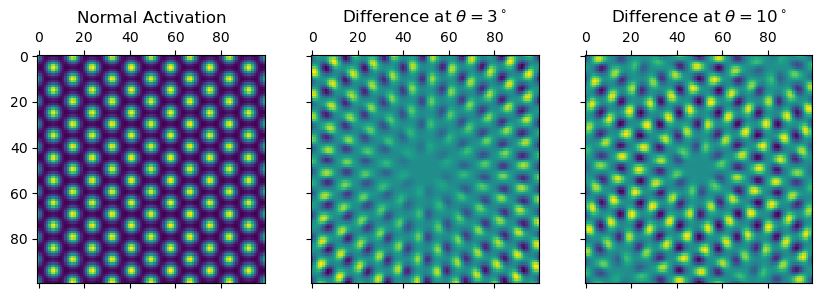

In [254]:
fig, ax = plt.subplots(1,3, figsize=(10,30), sharex=True, sharey=True)

ax[0].matshow(Z1)
ax[0].set_title("Normal Activation")

ax[1].matshow(Z2-Z1)
ax[1].set_title(r"Difference at $\theta=3^\circ$")

ax[2].matshow(Z3-Z1)
ax[2].set_title(r"Difference at $\theta=10^\circ$")

plt.show()

### Variation

In [255]:
def show_theta_var(t=0,dt=0,ax=0):
    '''Plots the variation of grid response along the theta=t angle when 
    the grids have a difference in theta of dt'''
    r = np.linspace(-R,R,num_points)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1,t0=-dt,N=N)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
    signal = Z2-Z1

    if ax!=0:
        ax.plot(r,signal)

        peaklocs, _ = sp.signal.find_peaks(signal)
        peaklocs2, _ = sp.signal.find_peaks(signal[peaklocs])
        troughlocs, _ = sp.signal.find_peaks(-signal)
        troughlocs2, _ = sp.signal.find_peaks(-signal[troughlocs])
        ax.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        ax.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')

        print(f"\n For {t} and {dt} Monotonicity of peaks break at {r[peaklocs][peaklocs2]}")
        print(f"Monotonicity of troughs break at {r[troughlocs][troughlocs2]} \n")
        
        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    else:
        plt.plot(r,signal)
        
        peaklocs, _ = sp.signal.find_peaks(signal)
        peaklocs2, _ = sp.signal.find_peaks(signal[peaklocs])
        troughlocs, _ = sp.signal.find_peaks(-signal)
        troughlocs2, _ = sp.signal.find_peaks(-signal[troughlocs])
        plt.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        plt.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')

        print(f"\n For {t} and {dt} Monotonicity of peaks break at {r[peaklocs][peaklocs2]}")
        print(f"Monotonicity of troughs break at {r[troughlocs][troughlocs2]}")

        plt.title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$ \n")
    # Z3 = GaussLattice(x,y,X3,Y3,s=0.2)

def show_dist_var(t=0,dl=0,ax=0):
    '''Plots the variation of grid response along the theta=t angle when 
    the grids have a difference in lambda of dl'''
    r = np.linspace(-R,R,num_points)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1+dl,t0=0,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
    signal = Z2-Z1

    if ax!=0:
        ax.plot(r,signal)

        peaklocs, _ = sp.signal.find_peaks(signal)
        peaklocs2, _ = sp.signal.find_peaks(signal[peaklocs])
        troughlocs, _ = sp.signal.find_peaks(-signal)
        troughlocs2, _ = sp.signal.find_peaks(-signal[troughlocs])
        ax.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        ax.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')

        print(f"\n For {t} and {dl} Monotonicity of peaks break at {r[peaklocs][peaklocs2]}")
        print(f"Monotonicity of troughs break at {r[troughlocs][troughlocs2]} \n")

        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\lambda=$" +f"{dl}")
    else:
        plt.plot(r,signal)
        
        peaklocs, _ = sp.signal.find_peaks(signal)
        peaklocs2, _ = sp.signal.find_peaks(signal[peaklocs])
        troughlocs, _ = sp.signal.find_peaks(-signal)
        troughlocs2, _ = sp.signal.find_peaks(-signal[troughlocs])
        plt.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        plt.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')

        print(f"\n For {t} and {dl} Monotonicity of peaks break at {r[peaklocs][peaklocs2]}")
        print(f"Monotonicity of troughs break at {r[troughlocs][troughlocs2]} \n")
        
        plt.title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\lambda=$" +f"{dl}")

In [256]:
def show_theta_var_conv(t=0,dt=0,ax=0):
    '''Plots the variation of grid response along the theta=t angle when 
    the grids have a difference in theta of t0'''
    r = np.linspace(-R,R,num_points)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1,t0=dt,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)

    plt1 = sp.ndimage.gaussian_filter(Z2-Z1,sigma=8)
    # plt1 = sp.ndimage.gaussian_filter(Z1-Z2,sigma=1)

    if ax!=0:
        ax.plot(r,plt1)
        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    else:
        plt.plot(r,plt1)
        plt.title(r"Smooth Diff of activity along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    # Z3 = GaussLattice(x,y,X3,Y3,s=0.2)

def show_dist_var_conv(t=0,dl=0,ax=0):
    '''Plots the variation of grid rsponse along the theta=t angle when 
    the grids have a difference in theta of t0'''
    r = np.linspace(-R,R,num_points)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1+dl,t0=0,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)

    plt1 = sp.ndimage.gaussian_filter(Z2-Z1,sigma=8)
    # plt1 = sp.ndimage.gaussian_filter(Z1-Z2,sigma=1)

    if ax!=0:
        ax.plot(r,plt1)
        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta\lambda=$" +f"{dl}" +r"$^\circ$")
    else:
        plt.plot(r,plt1)
        plt.title(r"Smooth Diff of activity along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta\lambda=$" +f"{dl}" +r"$^\circ$")
    # Z3 = GaussLattice(x,y,X3,Y3,s=0.2)


 For 90 and 10 Monotonicity of peaks break at [-14.62925852 -10.3006012   -4.52905812   0.04008016   4.52905812
  10.3006012   14.62925852]
Monotonicity of troughs break at [-17.99599198 -13.0260521   -7.01402806  -3.00601202   3.00601202
   7.01402806  13.0260521   17.99599198] 


 For 90 and 3 Monotonicity of peaks break at [-16.55310621  -0.04008016  16.55310621]
Monotonicity of troughs break at [-17.99599198 -15.99198397 -11.02204409  11.02204409  15.99198397
  17.99599198] 



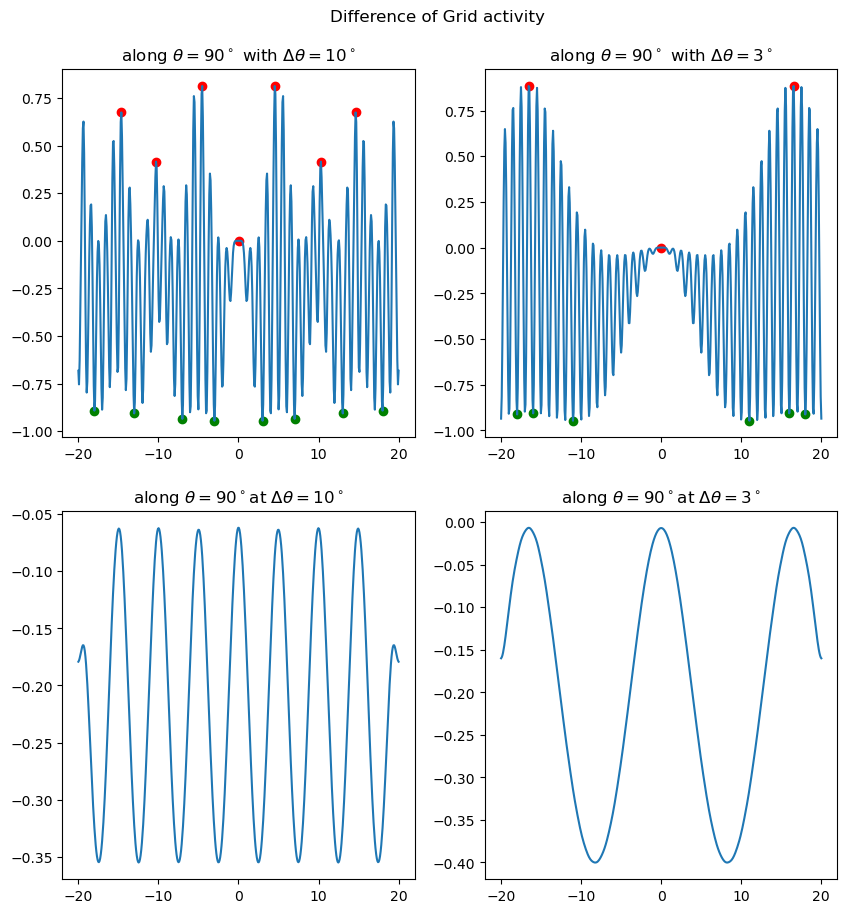

In [257]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.suptitle("Difference of Grid activity")
fig.tight_layout = True
fig.subplots_adjust(top=0.92)

angle = 90
show_theta_var(angle,10, ax[0,0])
show_theta_var(angle,3, ax[0,1])
show_theta_var_conv(angle,10, ax[1,0])
show_theta_var_conv(angle,3, ax[1,1])
plt.show()


 For 90 and 0.3 Monotonicity of peaks break at [-15.59118236 -10.46092184  -6.53306613  -2.60521042   2.60521042
   6.53306613  10.46092184  15.59118236]
Monotonicity of troughs break at [-15.03006012 -11.02204409  -7.01402806  -1.96392786   1.96392786
   7.01402806  11.02204409  15.03006012] 


 For 90 and 0.03 Monotonicity of peaks break at [-17.51503006  17.51503006]
Monotonicity of troughs break at [-17.99599198 -15.99198397  15.99198397  17.99599198] 



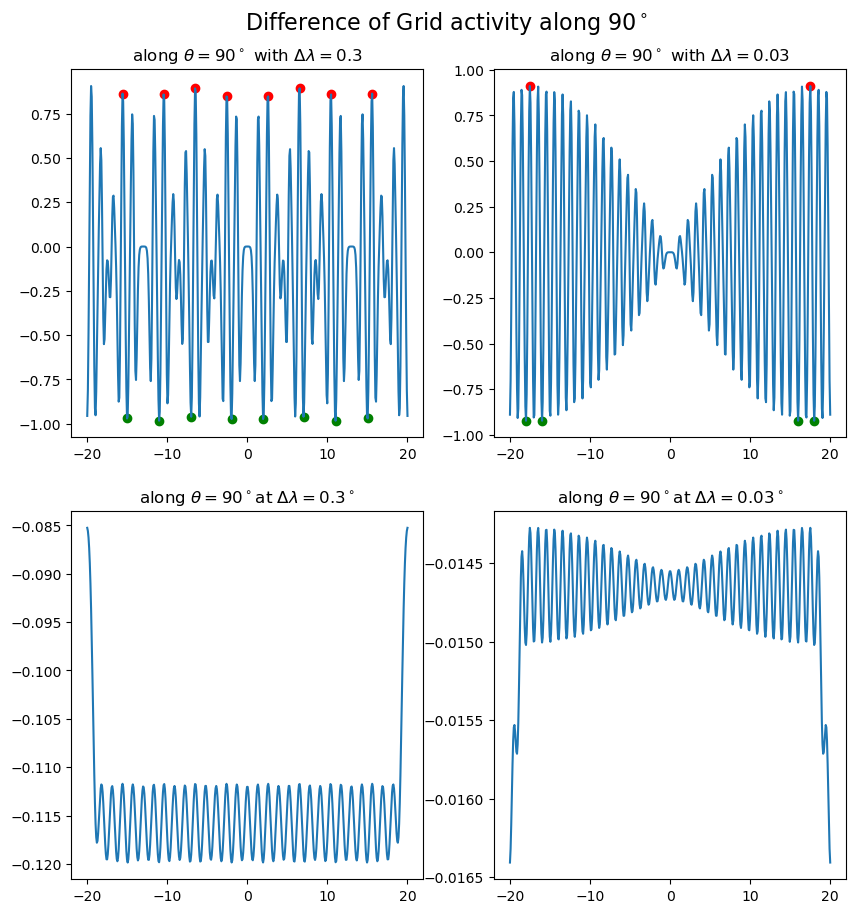

In [258]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.suptitle(f"Difference of Grid activity along {angle}"+r"$^\circ$", size=16)
fig.tight_layout = True
fig.subplots_adjust(top=0.92)

show_dist_var(angle,0.3, ax[0,0])
show_dist_var(angle,0.03, ax[0,1])
show_dist_var_conv(angle,0.3, ax[1,0])
show_dist_var_conv(angle,0.03, ax[1,1])
plt.show()

### Full page comparison plots

In [259]:
def plot_theta(angle, figlabel):
    fig, ax = plt.subplots(2, 4, figsize=(20,10))
    plt.suptitle(f"Difference of Grid activity along {angle}"+r"$^\circ$", size=16)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.92)

    dts = [2,4,6,8,-2,-4,-6,-8]
    labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    for i, axis in enumerate(ax.flatten()):
        show_theta_var(angle, dts[i], axis)
        # axis.annotate(labels[i], xy=(0,1))
        axis.text(-0.02, 1.03, figlabel+str(i+1) , transform=axis.transAxes, size=20, weight='bold')
        # axis.text(-0.02, 1.02, string.ascii_uppercase[i], transform=axis.transAxes, size=20, weight='bold')

    # show_theta_var(angle,2, ax[0,0])
    # show_theta_var(angle,4, ax[0,1])
    # show_theta_var(angle,6, ax[0,2])
    # show_theta_var(angle,8, ax[0,3])

    # show_theta_var(angle,-2, ax[1,0])
    # show_theta_var(angle,-4, ax[1,1])
    # show_theta_var(angle,-6, ax[1,2])
    # show_theta_var(angle,-8, ax[1,3])

    plt.show()

def plot_theta_conv(angle, figlabel):
    fig, ax = plt.subplots(2, 4, figsize=(20,10))
    plt.suptitle(f"Smoothed (Gaussian convolved) difference of Grid activity along {angle}"+r"$^\circ$", size=16)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.92)

    dts = [2,4,6,8,-2,-4,-6,-8]
    labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    for i, axis in enumerate(ax.flatten()):
        show_theta_var_conv(angle, dts[i], axis)
        # axis.annotate(labels[i], xy=(0,1))
        axis.text(-0.02, 1.03, figlabel+str(i+1) , transform=axis.transAxes, size=20, weight='bold')
        # axis.text(-0.02, 1.02, string.ascii_uppercase[i], transform=axis.transAxes, size=20, weight='bold')

    # show_theta_var(angle,2, ax[0,0])
    # show_theta_var(angle,4, ax[0,1])
    # show_theta_var(angle,6, ax[0,2])
    # show_theta_var(angle,8, ax[0,3])

    # show_theta_var(angle,-2, ax[1,0])
    # show_theta_var(angle,-4, ax[1,1])
    # show_theta_var(angle,-6, ax[1,2])
    # show_theta_var(angle,-8, ax[1,3])

    plt.show()


 For 88 and 2 Monotonicity of peaks break at [-17.99599198 -15.99198397  15.99198397  17.99599198]
Monotonicity of troughs break at [0.04008016] 


 For 88 and 4 Monotonicity of peaks break at [-11.02204409  -8.93787575  -7.01402806  -3.96793587   0.12024048
   7.01402806   8.93787575  11.02204409]
Monotonicity of troughs break at [-18.55711423 -14.5490982  -10.54108216  -6.45290581  -3.40681363
  -1.32264529  -0.2004008    1.32264529   3.40681363   6.45290581
  10.54108216  14.5490982   18.55711423] 


 For 88 and 6 Monotonicity of peaks break at [-12.54509018  -0.04008016  12.54509018]
Monotonicity of troughs break at [-16.15230461  -5.01002004   5.01002004  16.15230461] 


 For 88 and 8 Monotonicity of peaks break at [-16.07214429  -8.53707415  -0.04008016   8.53707415  16.07214429]
Monotonicity of troughs break at [-3.96793587  3.96793587] 


 For 88 and -2 Monotonicity of peaks break at [-12.54509018   0.04008016  12.54509018]
Monotonicity of troughs break at [-16.15230461  -5.01

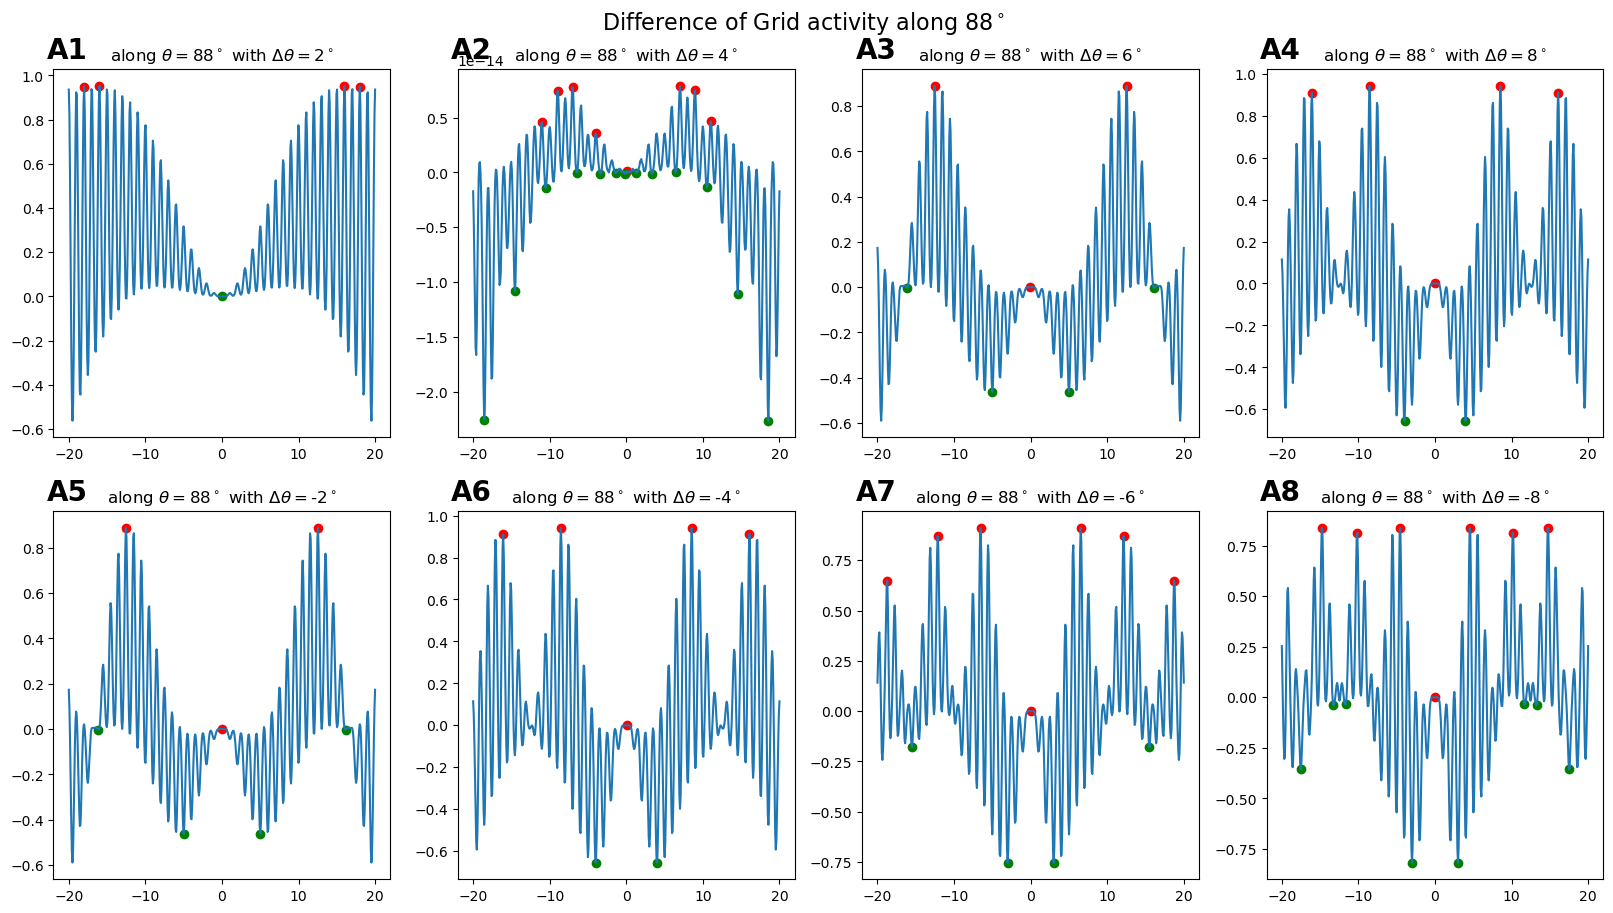

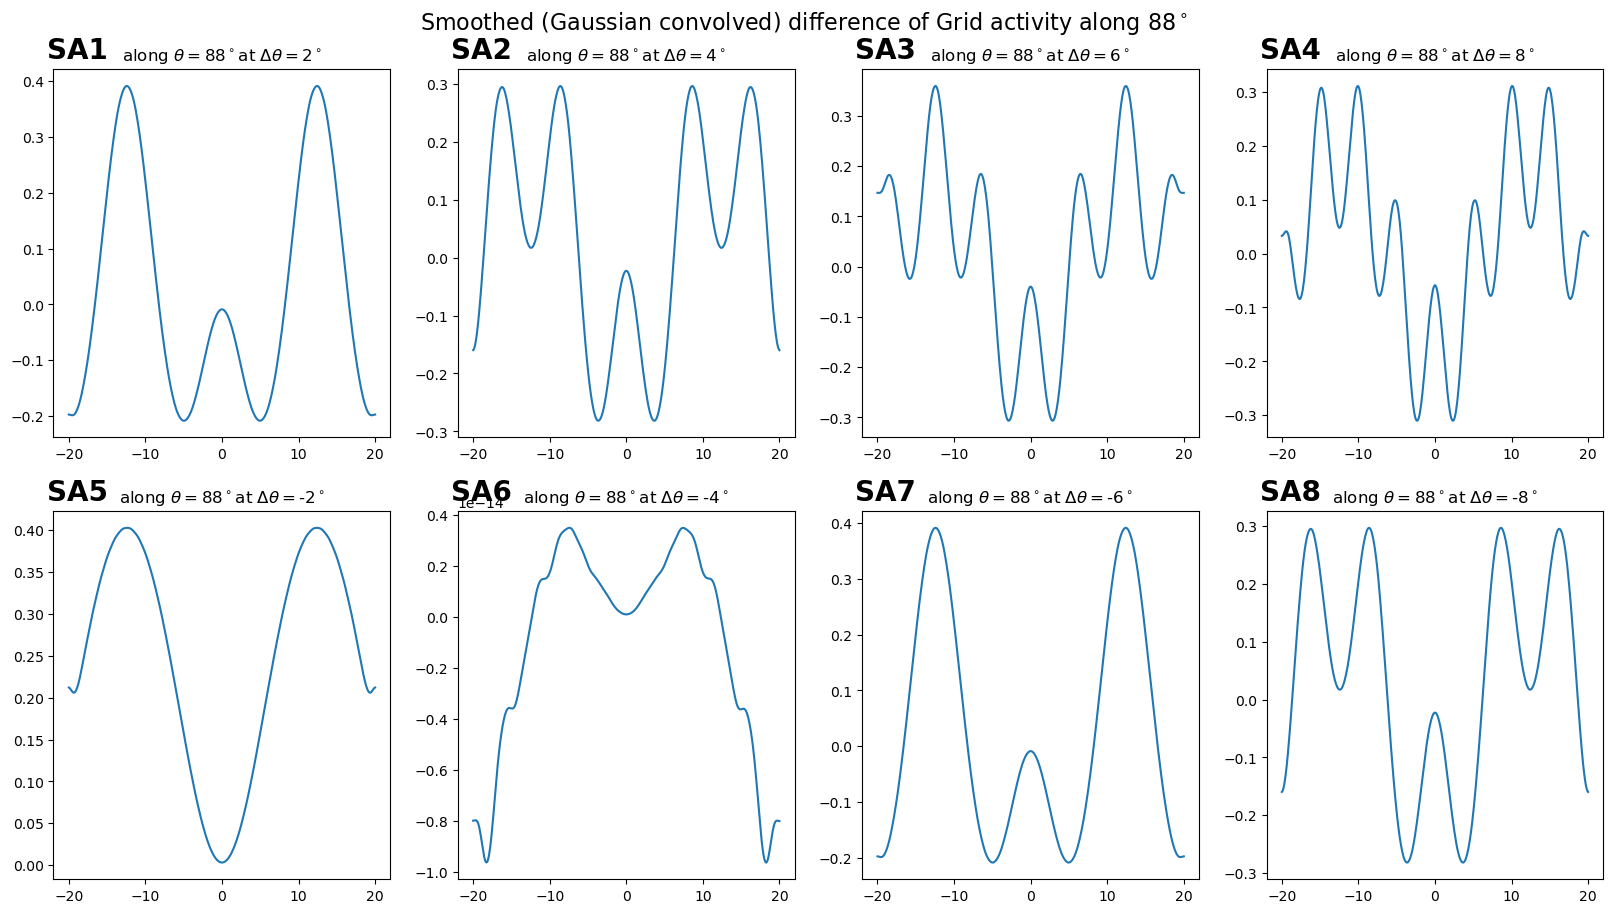


 For 90 and 2 Monotonicity of peaks break at [0.04008016]
Monotonicity of troughs break at [-17.99599198 -15.99198397  15.99198397  17.99599198] 


 For 90 and 4 Monotonicity of peaks break at [-12.54509018  -0.04008016  12.54509018]
Monotonicity of troughs break at [-15.99198397  -9.01803607   9.01803607  15.99198397] 


 For 90 and 6 Monotonicity of peaks break at [-16.23246493  -8.53707415  -0.04008016   8.53707415  16.23246493]
Monotonicity of troughs break at [-11.02204409  -5.01002004   5.01002004  11.02204409] 


 For 90 and 8 Monotonicity of peaks break at [-18.63727455 -12.30460922  -6.53306613  -0.04008016   6.53306613
  12.30460922  18.63727455]
Monotonicity of troughs break at [-15.99198397  -9.01803607  -3.96793587   3.96793587   9.01803607
  15.99198397] 


 For 90 and -2 Monotonicity of peaks break at [0.04008016]
Monotonicity of troughs break at [-17.99599198 -15.99198397  15.99198397  17.99599198] 


 For 90 and -4 Monotonicity of peaks break at [-12.54509018   0.0400

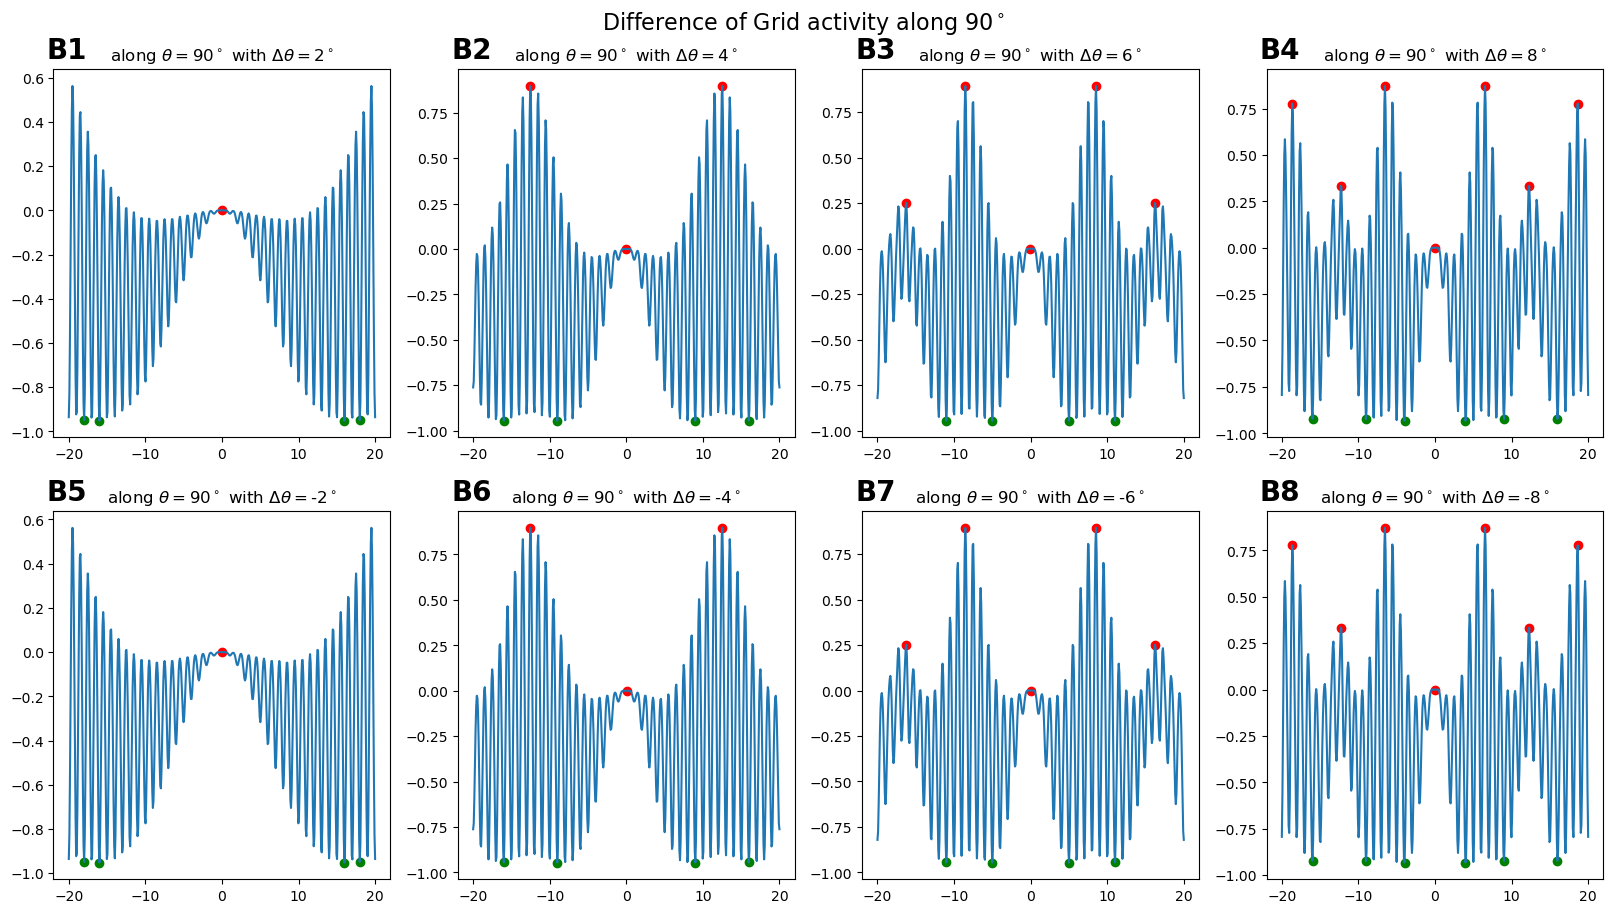

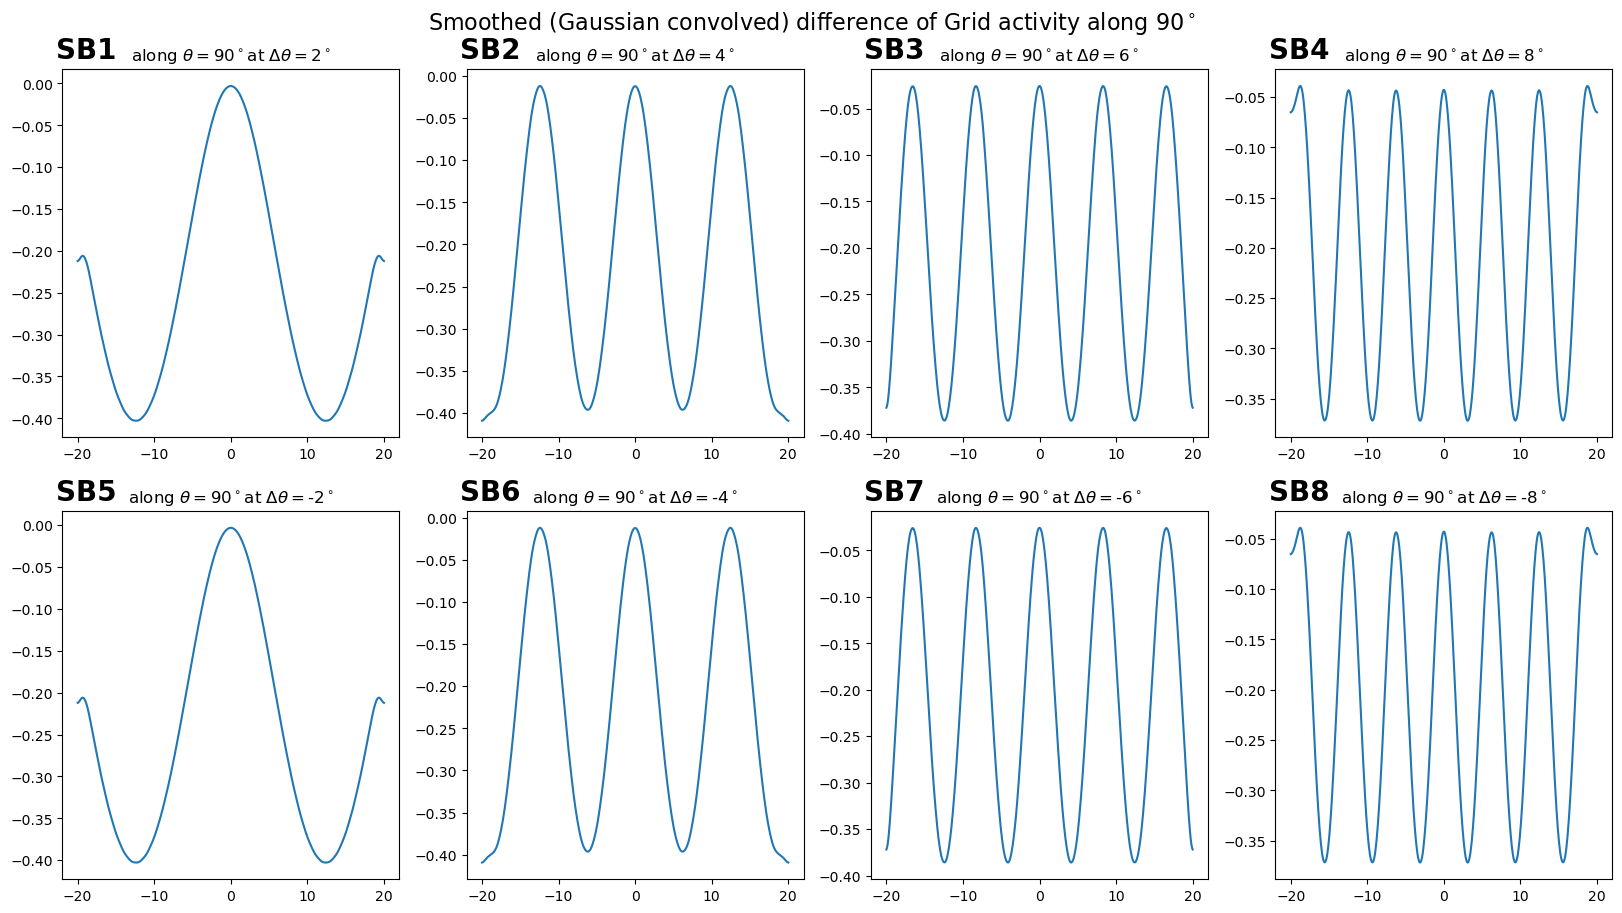


 For 92 and 2 Monotonicity of peaks break at [-12.54509018  -0.04008016  12.54509018]
Monotonicity of troughs break at [-16.15230461  -5.01002004   5.01002004  16.15230461] 


 For 92 and 4 Monotonicity of peaks break at [-16.07214429  -8.53707415  -0.04008016   8.53707415  16.07214429]
Monotonicity of troughs break at [-3.96793587  3.96793587] 


 For 92 and 6 Monotonicity of peaks break at [-18.71743487 -12.14428858  -6.53306613  -0.04008016   6.53306613
  12.14428858  18.71743487]
Monotonicity of troughs break at [-15.51102204  -3.00601202   3.00601202  15.51102204] 


 For 92 and 8 Monotonicity of peaks break at [-14.78957916 -10.14028056  -4.52905812  -0.04008016   4.52905812
  10.14028056  14.78957916]
Monotonicity of troughs break at [-17.51503006 -13.26653307 -11.66332665  -3.00601202   3.00601202
  11.66332665  13.26653307  17.51503006] 


 For 92 and -2 Monotonicity of peaks break at [-17.99599198 -15.99198397  15.99198397  17.99599198]
Monotonicity of troughs break at [0.04

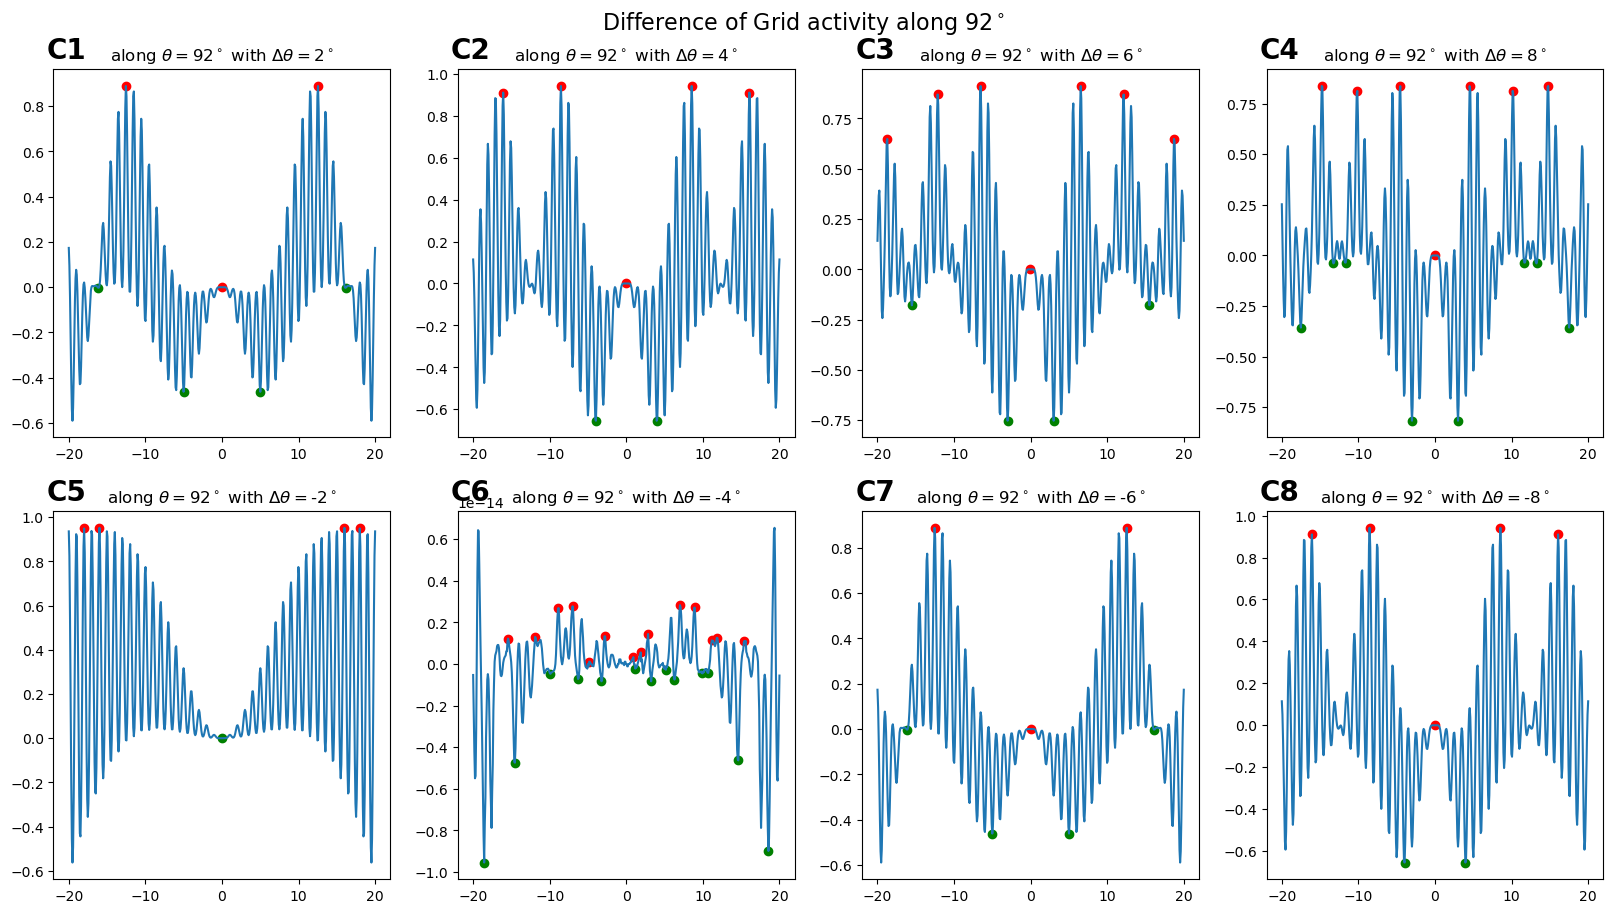

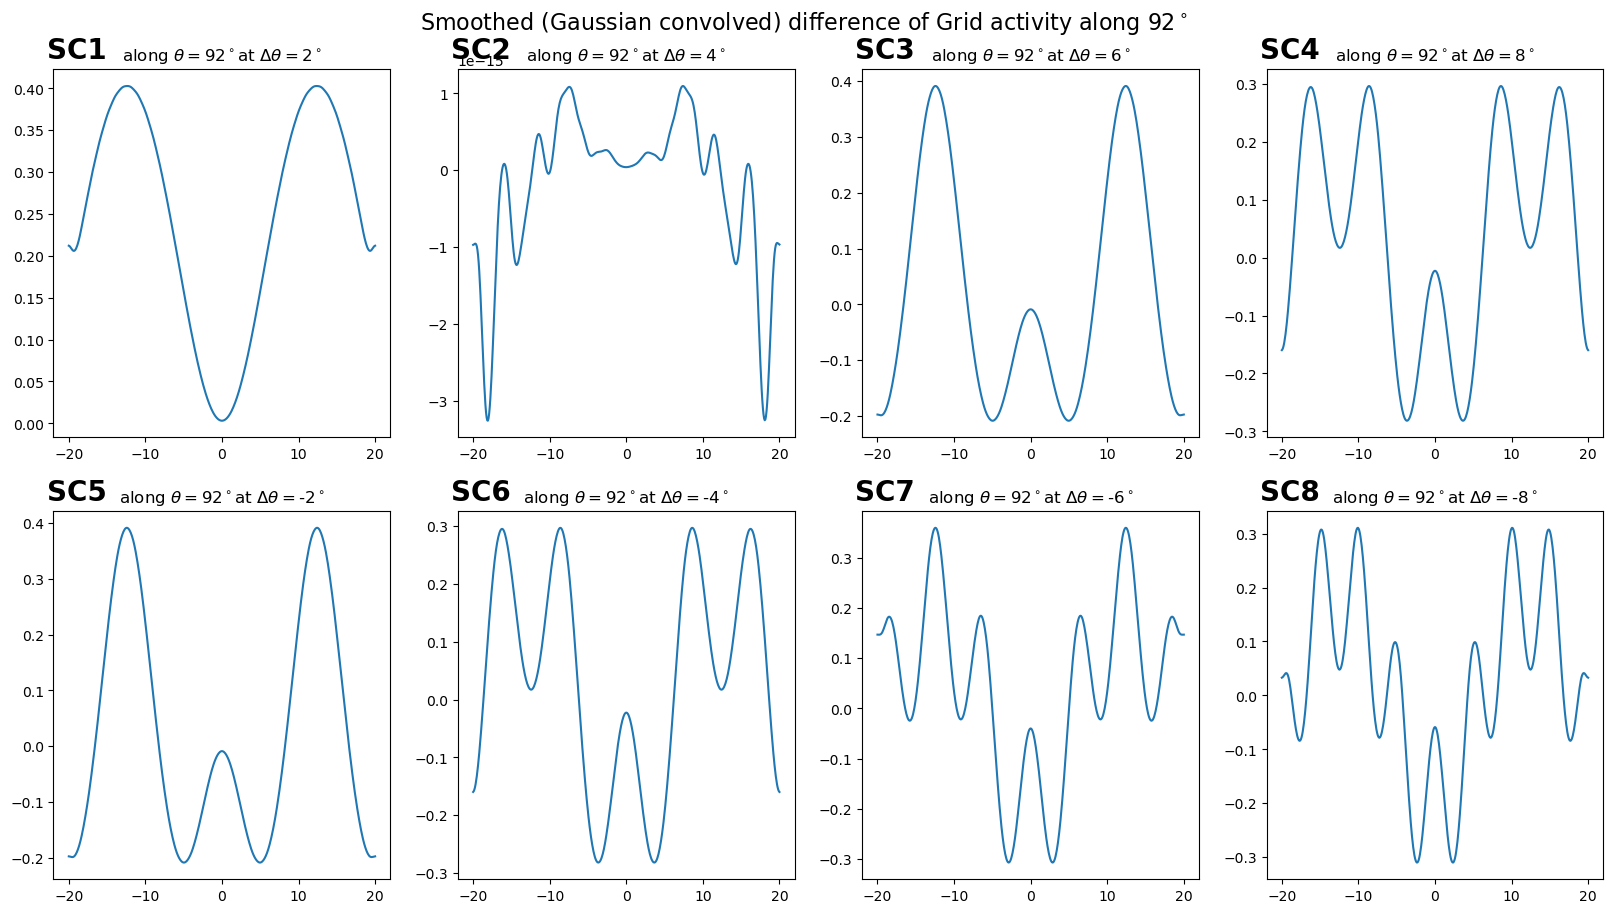

In [260]:
plot_theta(88, 'A')
plot_theta_conv(88, 'SA')
plot_theta(90, 'B')
plot_theta_conv(90, 'SB')
plot_theta(92, 'C')
plot_theta_conv(92, 'SC')

### Animation (To-Do)

## Metric of monotonicity

### Simple uniform distance

In [261]:
def monometric_theta(t=0, dt=0, ax=0):
    l = 1
    r = np.arange(-20,20,l)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1,t0=dt,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)

    if ax!=0:
        ax.scatter(r,Z1-Z2)
        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    else:
        plt.scatter(r,Z1-Z2)
        plt.title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")

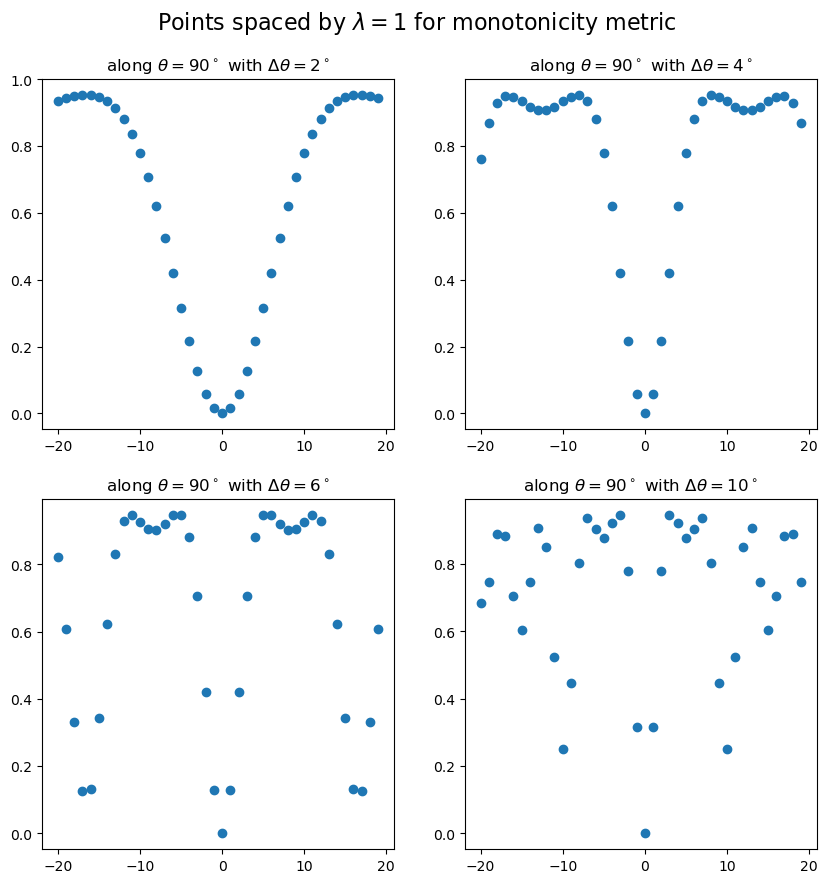

In [262]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.tight_layout = True
fig.suptitle(r"Points spaced by $\lambda=1$ for monotonicity metric", size=16, y=0.95)
fig.subplots_adjust(top=0.88)

monometric_theta(90, 2, ax[0,0]) 
monometric_theta(90, 4, ax[0,1]) 
monometric_theta(90, 6, ax[1,0]) 
monometric_theta(90, 10, ax[1,1]) 


 For 90 and 2 Monotonicity of peaks break at [0.04008016]
Monotonicity of troughs break at [-17.99599198 -15.99198397  15.99198397  17.99599198] 


 For 90 and 4 Monotonicity of peaks break at [-12.54509018  -0.04008016  12.54509018]
Monotonicity of troughs break at [-15.99198397  -9.01803607   9.01803607  15.99198397] 


 For 90 and 6 Monotonicity of peaks break at [-16.23246493  -8.53707415  -0.04008016   8.53707415  16.23246493]
Monotonicity of troughs break at [-11.02204409  -5.01002004   5.01002004  11.02204409] 


 For 90 and 10 Monotonicity of peaks break at [-14.62925852 -10.3006012   -4.52905812   0.04008016   4.52905812
  10.3006012   14.62925852]
Monotonicity of troughs break at [-17.99599198 -13.0260521   -7.01402806  -3.00601202   3.00601202
   7.01402806  13.0260521   17.99599198] 



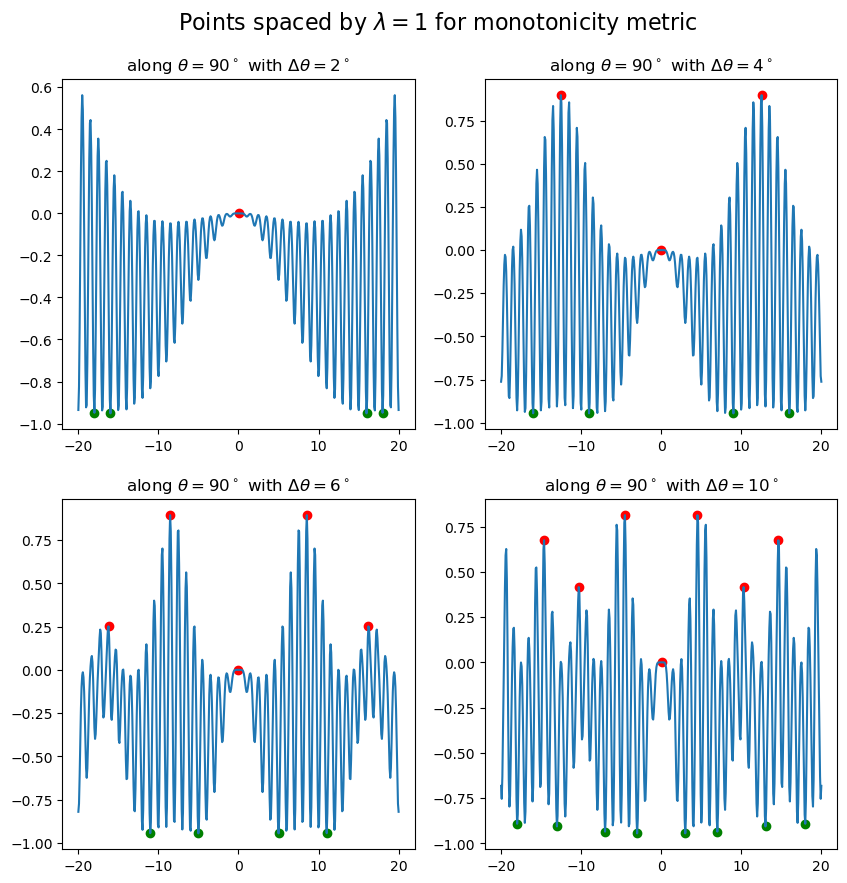

In [263]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.tight_layout = True
fig.suptitle(r"Points spaced by $\lambda=1$ for monotonicity metric", size=16, y=0.95)
fig.subplots_adjust(top=0.88)

show_theta_var(90, 2, ax[0,0]) 
show_theta_var(90, 4, ax[0,1]) 
show_theta_var(90, 6, ax[1,0]) 
show_theta_var(90, 10, ax[1,1]) 

### Peak finding

In [264]:
def plotpeak_theta(t=0,dt=0,ax=0):
    '''Plots the peaks of variation of grid response along the theta=t angle when 
    the grids have a difference in theta of dt and returns the points of monotomicity breaking'''
    r = np.linspace(-15,15,500)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1,t0=dt,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
    signal = Z1 - Z2
    sp.signal.find_peaks(signal)

    if ax!=0:
        ax.plot(r,Z1-Z2)
        ax.set_title(r"Diff of grid activity along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    else:
        plt.plot(r,Z1-Z2)
        plt.title(r"Diff of grid activity along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    # Z3 = GaussLattice(x,y,X3,Y3,s=0.2)

[-16.98396794  -7.96593186   7.96593186  16.98396794]


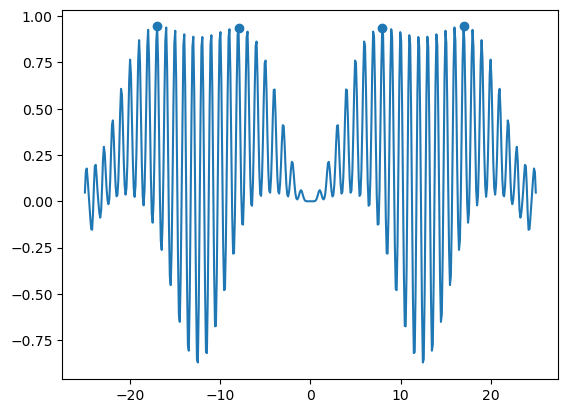

In [265]:
t=90
dt=4
r = np.linspace(-25,25,500)
theta = np.radians(t)
x = r*np.cos(theta)
y = r*np.sin(theta)

X1,Y1 = Lattice(l=1,t0=0,N=N)
X2,Y2 = Lattice(l=1,t0=dt,N=N)
# X3,Y3 = Lattice(l=1,t0=10,N=10)

Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
signal = Z1 - Z2
plt.plot(r,signal)

locs, _ = sp.signal.find_peaks(signal)
# plt.scatter(r[locs], signal[locs])
locs2, _ = sp.signal.find_peaks(signal[locs])
plt.scatter(r[locs][locs2], signal[locs][locs2])
print(r[locs][locs2])